In [3]:
# delete packages and install from requirements.txt
# !pip uninstall -y -r requirements.txt
!pip install -r requirements.txt
!pip freeze > requirements.txt

You should consider upgrading via the 'C:\Users\mat_h\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [17]:
import pandas as pd
import numpy as np
import ta
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import joblib # Para salvar scalers e modelos sklearn

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [5]:
def download_stock_data(ticker, start_date, end_date):
    """
    Downloads historical stock data for a given ticker symbol between specified dates.

    Parameters:
    ticker (str): The stock ticker symbol.
    start_date (str): The start date in 'YYYY-MM-DD' format.
    end_date (str): The end date in 'YYYY-MM-DD' format.

    Returns:
    pd.DataFrame: A DataFrame containing the stock data.
    """
    stock = yf.download(ticker, start=start_date, end=end_date)
    data = stock.xs(ticker, level="Ticker", axis=1)
    if data.empty:
        raise ValueError(f"No data found for ticker {ticker} between {start_date} and {end_date}.")
    return data

In [6]:
df = download_stock_data('PETR4.SA', '2020-01-01', '2025-01-01')
df.head()

C:\Users\mat_h\AppData\Local\Temp\ipykernel_24148\3599526879.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Date,,,,,
2020-01-02,9.304729,9.304729,9.186526,9.247143,37774500
2020-01-03,9.228958,9.468395,9.228958,9.359284,71595600
2020-01-06,9.338068,9.377469,9.077415,9.222896,81844000
2020-01-07,9.301700,9.359286,9.235020,9.341101,32822000
2020-01-08,9.244111,9.325944,9.165309,9.301697,48215600


## Preenchendo valores nulos

In [7]:
df_filled = df.copy()
df_filled['Close'] = df_filled['Close'].fillna(method='ffill')
df_filled['Volume'] = df_filled['Volume'].fillna(method='ffill')
df_filled['High'] = df_filled['High'].fillna(method='ffill')
df_filled['Low'] = df_filled['Low'].fillna(method='ffill')

C:\Users\mat_h\AppData\Local\Temp\ipykernel_24148\4096485336.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled['Close'] = df_filled['Close'].fillna(method='ffill')
C:\Users\mat_h\AppData\Local\Temp\ipykernel_24148\4096485336.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled['Volume'] = df_filled['Volume'].fillna(method='ffill')
C:\Users\mat_h\AppData\Local\Temp\ipykernel_24148\4096485336.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled['High'] = df_filled['High'].fillna(method='ffill')
C:\Users\mat_h\AppData\Local\Temp\ipykernel_24148\4096485336.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_

## Feature engenniring 

### Momentum 

In [8]:
df['RSI'] = ta.momentum.rsi(df_filled['Close'], window=14) # Relative Strength Index
df['MACD'] = ta.trend.macd(df_filled['Close']) # Moving Average Convergence Divergence (também mede tendência)

### Tendência

In [9]:
df['SMA_10'] = ta.trend.sma_indicator(df_filled['Close'], window=10) # Simple Moving Average
df['SMA_50'] = ta.trend.sma_indicator(df_filled['Close'], window=50) # Simple Moving Average
df['SMA_200'] = ta.trend.sma_indicator(df_filled['Close'], window=200) # Simple Moving Average
df['EMA_10'] = ta.trend.ema_indicator(df_filled['Close'], window=10) # Exponential Moving Average
df['EMA_50'] = ta.trend.ema_indicator(df_filled['Close'], window=50) # Exponential Moving Average
df['EMA_200'] = ta.trend.ema_indicator(df_filled['Close'], window=200) # Exponential Moving Average

### Volatilidade

In [10]:
df['ART'] = ta.volatility.average_true_range(df_filled['High'], df_filled['Low'], df_filled['Close'], window=14) # Average True Range
df['BB_High'] = ta.volatility.bollinger_hband(df_filled['Close'], window=20, window_dev=2) # [23, 24, 25, 26, 2, 27, 28, 29, 30, 31, 32, 33]
df['BB_MM'] = ta.volatility.bollinger_mavg(df_filled['Close'], window=20) # [23, 24, 25, 26, 2, 27, 28, 29, 30, 31, 32, 33]
df['BB_Lower'] = ta.volatility.bollinger_lband(df_filled['Close'], window=20, window_dev=2) # [23, 24, 25, 26, 2, 27, 28, 29, 30, 31, 32, 33]
df['BB_Width'] = ta.volatility.bollinger_wband(df_filled['Close'], window=20, window_dev=2) # Largura das Bandas de Bollinger [34, 35, 36, 29]

### Volume

In [11]:

df['Volume_OBV'] = ta.volume.on_balance_volume(df_filled['Close'], df_filled['Volume']) # On-Balance Volume

In [12]:
df = df.dropna()
df.tail()

Price,Close,High,Low,Open,Volume,RSI,MACD,SMA_10,SMA_50,SMA_200,EMA_10,EMA_50,EMA_200,ART,BB_High,BB_MM,BB_Lower,BB_Width,Volume_OBV
Date,,,,,,,,,,,,,,,,,,,
2024-12-20,33.637844,34.094260,33.510048,33.920823,59277400,45.608787,0.309050,34.705957,33.115926,32.035755,34.366700,33.553521,31.718342,0.668507,35.526988,34.532398,33.537808,5.760331,4646570200
2024-12-23,33.646973,33.820409,33.519177,33.774769,43785600,45.716658,0.227884,34.555405,33.127781,32.066134,34.235840,33.557186,31.737532,0.642273,35.561050,34.494873,33.428697,6.181650,4690355800
2024-12-26,33.899914,34.117889,33.738800,33.767234,22920700,48.749669,0.181873,34.416978,33.145221,32.093252,34.174763,33.570626,31.759048,0.630033,35.568309,34.472190,33.376072,6.359436,4713276500
2024-12-27,33.795662,34.117887,33.748277,34.117887,24167200,47.569922,0.135436,34.233009,33.158997,32.121551,34.105835,33.579451,31.779313,0.611432,35.581570,34.450440,33.319311,6.566707,4689109300
2024-12-30,34.297951,34.468540,33.899910,33.909386,22355600,53.418916,0.137578,34.163008,33.188261,32.152980,34.140765,33.607627,31.804374,0.615821,35.574612,34.471364,33.368116,6.400954,4711464900


## Preparando os dados para treinamento

In [13]:
target = df['Close']
features = df[['RSI', 'MACD', 'SMA_10', 'SMA_50', 'SMA_200', 'EMA_10', 'EMA_50', 'EMA_200',
               'ART', 'BB_High', 'BB_MM', 'BB_Lower', 'BB_Width', 'Volume_OBV']]
X_ns = features.values
y_ns = target.values

In [14]:
train_split_ratio_ns = 0.8
train_size_ns = int(len(X_ns) * train_split_ratio_ns)

X_train_ns, X_test_ns = X_ns[:train_size_ns], X_ns[train_size_ns:]
y_train_ns, y_test_ns = y_ns[:train_size_ns], y_ns[train_size_ns:]

### Escalonamento

In [15]:
feature_scaler_ns = MinMaxScaler(feature_range=(0, 1))
X_train_scaled_ns = feature_scaler_ns.fit_transform(X_train_ns) # Fit e transform em treino
X_test_scaled_ns = feature_scaler_ns.transform(X_test_ns) # Apenas transform em teste

In [16]:
target_scaler_ns = MinMaxScaler(feature_range=(0, 1))
y_train_scaled_ns = target_scaler_ns.fit_transform(y_train_ns.reshape(-1, 1)) # Fit e transform em treino (reshape para 2D)
y_test_scaled_ns = target_scaler_ns.transform(y_test_ns.reshape(-1, 1)) # Apenas transform em teste

In [22]:
model_lr = LinearRegression()

# Treinar o modelo
model_lr.fit(X_train_scaled_ns, y_train_scaled_ns)

# Fazer previsões
predictions_scaled_lr = model_lr.predict(X_test_scaled_ns)


In [23]:
# Inverter o escalonamento das previsões para a escala original
predictions_lr = target_scaler_ns.inverse_transform(predictions_scaled_lr.reshape(-1, 1))
y_test_original_lr = target_scaler_ns.inverse_transform(y_test_scaled_ns)

In [24]:
# Avaliar o modelo
rmse_lr = np.sqrt(mean_squared_error(y_test_original_lr, predictions_lr))
mae_lr = mean_absolute_error(y_test_original_lr, predictions_lr)
r2_lr = r2_score(y_test_original_lr, predictions_lr)

print(f"RMSE (Regressão Linear): {rmse_lr:.4f}")
print(f"MAE (Regressão Linear): {mae_lr:.4f}")
print(f"R2 Score (Regressão Linear): {r2_lr:.4f}")

RMSE (Regressão Linear): 0.3384
MAE (Regressão Linear): 0.2476
R2 Score (Regressão Linear): 0.9615


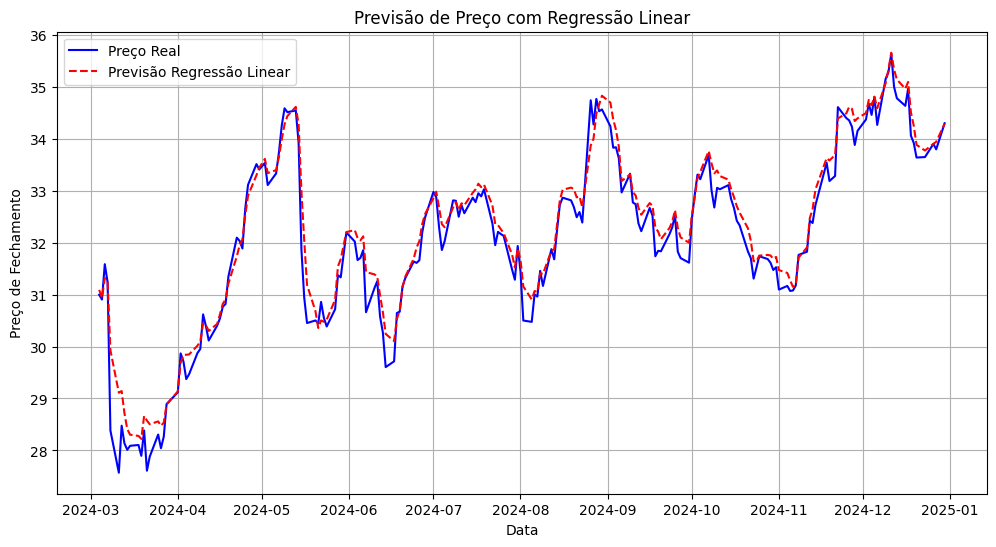

In [25]:
# Plotar resultados
plt.figure(figsize=(12, 6))
plt.plot(df.index[train_size_ns + (window_size if 'rnn' in locals() else 0):], y_test_original_lr, label='Preço Real', color='blue')
plt.plot(df.index[train_size_ns + (window_size if 'rnn' in locals() else 0):], predictions_lr, label='Previsão Regressão Linear', color='red', linestyle='--')
plt.title('Previsão de Preço com Regressão Linear')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
joblib.dump(model_lr, 'model_lr.pkl')
joblib.dump(feature_scaler_ns, 'feature_scaler_ns.pkl')
joblib.dump(target_scaler_ns, 'target_scaler_ns.pkl')
print("Modelo de Regressão Linear e scalers salvos.")

Modelo de Regressão Linear e scalers salvos.


### Arvore de decisão

In [ ]:
model_dt = DecisionTreeRegressor(random_state=42) # random_state para reprodutibilidade

In [29]:
# Treinar o modelo (usando dados escalados, embora não estritamente necessário para DT)
model_dt.fit(X_train_scaled_ns, y_train_scaled_ns)

# Fazer previsões
predictions_scaled_dt = model_dt.predict(X_test_scaled_ns)

# Inverter o escalonamento
predictions_dt = target_scaler_ns.inverse_transform(predictions_scaled_dt.reshape(-1, 1))
y_test_original_dt = target_scaler_ns.inverse_transform(y_test_scaled_ns)


In [30]:
rmse_dt = np.sqrt(mean_squared_error(y_test_original_dt, predictions_dt))
mae_dt = mean_absolute_error(y_test_original_dt, predictions_dt)
r2_dt = r2_score(y_test_original_dt, predictions_dt)

print(f"RMSE (Árvore de Decisão): {rmse_dt:.4f}")
print(f"MAE (Árvore de Decisão): {mae_dt:.4f}")
print(f"R2 Score (Árvore de Decisão): {r2_dt:.4f}")

RMSE (Árvore de Decisão): 3.6068
MAE (Árvore de Decisão): 2.6498
R2 Score (Árvore de Decisão): -3.3698


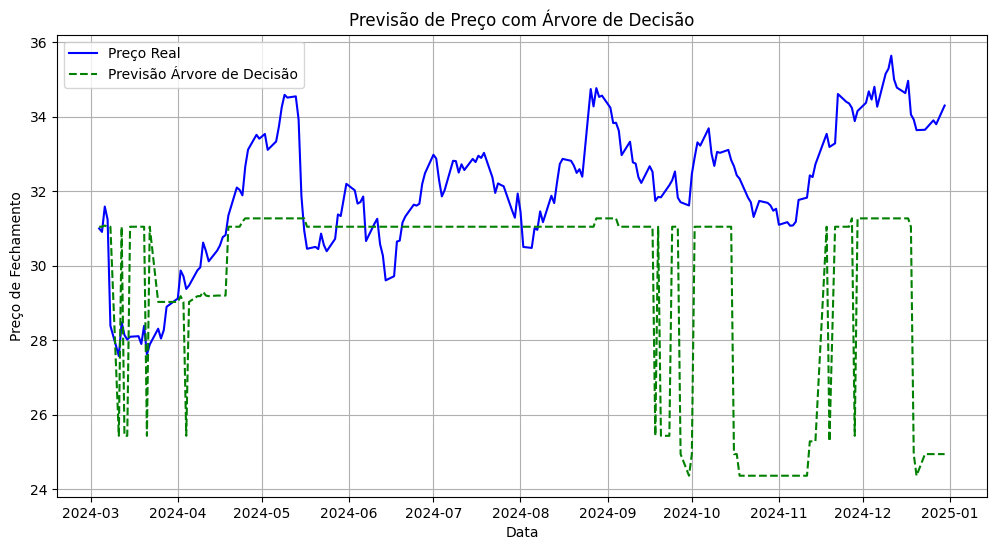

In [31]:
plt.figure(figsize=(12, 6))
plt.plot(df.index[train_size_ns + (window_size if 'rnn' in locals() else 0):], y_test_original_dt, label='Preço Real', color='blue')
plt.plot(df.index[train_size_ns + (window_size if 'rnn' in locals() else 0):], predictions_dt, label='Previsão Árvore de Decisão', color='green', linestyle='--')
plt.title('Previsão de Preço com Árvore de Decisão')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.grid(True)
plt.show()

### RNN - LSTM

In [42]:
features_cols = [
    'Close','High','Low','Open','Volume','RSI','MACD','SMA_10','SMA_50','SMA_200','EMA_10','EMA_50','EMA_200','ART','BB_High','BB_MM','BB_Lower','BB_Width','Volume_OBV'
]
target_col = 'Close'

In [45]:
window_size = 30 # Usaremos 30 dias de dados históricos
def create_sequences(data, window_size, features_cols, target_col):
    X, y = [], []
    for i in range(len(data) - window_size):
        window_features = data.iloc[i : (i + window_size)][features_cols].values
        # O valor alvo é o 'Target_Close' do último dia da janela
        target_value = data.iloc[i + window_size - 1][target_col]
        X.append(window_features)
        y.append(target_value)
    return np.array(X), np.array(y)

In [44]:
X_rnn_raw, y_rnn_raw = create_sequences(df, window_size, features_cols, target_col)


In [47]:
train_split_ratio_rnn = 0.8
train_size_rnn = int(len(X_rnn_raw) * train_split_ratio_rnn)

In [ ]:
X_train_rnn_raw, X_test_rnn_raw = X_rnn_raw[:train_size_rnn], X_rnn_raw[train_size_rnn:]
y_train_rnn_raw, y_test_rnn_raw = y_rnn_raw[:train_size_rnn], y_rnn_raw[train_size_rnn:]



Shapes para treino/teste (RNN):
X_train_rnn_raw: (812, 30, 19), y_train_rnn_raw: (812,)
X_test_rnn_raw: (203, 30, 19), y_test_rnn_raw: (203,)


In [52]:
feature_scaler_rnn = MinMaxScaler(feature_range=(0, 1))
X_train_flat_rnn = X_train_rnn_raw.reshape(-1, X_train_rnn_raw.shape[-1])
X_test_flat_rnn = X_test_rnn_raw.reshape(-1, X_test_rnn_raw.shape[-1])


feature_scaler_rnn.fit(X_train_flat_rnn)
X_train_scaled_rnn = feature_scaler_rnn.transform(X_train_flat_rnn).reshape(X_train_rnn_raw.shape)
X_test_scaled_rnn = feature_scaler_rnn.transform(X_test_flat_rnn).reshape(X_test_rnn_raw.shape)

target_scaler_rnn = MinMaxScaler(feature_range=(0, 1))
y_train_scaled_rnn = target_scaler_rnn.fit_transform(y_train_rnn_raw.reshape(-1, 1))
y_test_scaled_rnn = target_scaler_rnn.transform(y_test_rnn_raw.reshape(-1, 1))


In [53]:
model_rnn = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(window_size, X_train_scaled_rnn.shape[2])),
    Dropout(0.2),
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(units=1) # Saída para um único valor (preço)
])

c:\Users\mat_h\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [54]:
model_rnn.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])


In [55]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# ReduceLROnPlateau: para reduzir a taxa de aprendizado se a validação não melhorar
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)


In [73]:
history = model_rnn.fit(
    X_train_scaled_rnn, y_train_scaled_rnn,
    epochs=100, # Número de épocas, ajuste conforme necessário
    batch_size=31, # Tamanho do batch
    validation_data=(X_test_scaled_rnn, y_test_scaled_rnn), # Usar dados de teste como validação
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0020 - mean_absolute_error: 0.0300 - val_loss: 0.0015 - val_mean_absolute_error: 0.0324 - learning_rate: 1.0000e-05
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0016 - mean_absolute_error: 0.0278 - val_loss: 0.0014 - val_mean_absolute_error: 0.0304 - learning_rate: 1.0000e-05
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0019 - mean_absolute_error: 0.0296 - val_loss: 0.0014 - val_mean_absolute_error: 0.0306 - learning_rate: 1.0000e-05
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0017 - mean_absolute_error: 0.0293 - val_loss: 0.0015 - val_mean_absolute_error: 0.0317 - learning_rate: 1.0000e-05
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0015 - mean_absolute_error: 0.0288 - val_loss: 0.0016 - val_mean_absolute_error: 0.0327 - learning_rate: 1.0000e-05
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0015 - mean_absolute_error: 0.0276 - val_loss: 0

In [74]:
predictions_scaled_rnn = model_rnn.predict(X_test_scaled_rnn)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [75]:
predictions_rnn = target_scaler_rnn.inverse_transform(predictions_scaled_rnn)
y_test_original_rnn = target_scaler_rnn.inverse_transform(y_test_scaled_rnn)

In [76]:
rmse_rnn = np.sqrt(mean_squared_error(y_test_original_rnn, predictions_rnn))
mae_rnn = mean_absolute_error(y_test_original_rnn, predictions_rnn)
r2_rnn = r2_score(y_test_original_rnn, predictions_rnn)

print(f"RMSE (LSTM): {rmse_rnn:.4f}")
print(f"MAE (LSTM): {mae_rnn:.4f}")
print(f"R2 Score (LSTM): {r2_rnn:.4f}")

RMSE (LSTM): 0.9591
MAE (LSTM): 0.7838
R2 Score (LSTM): 0.6890


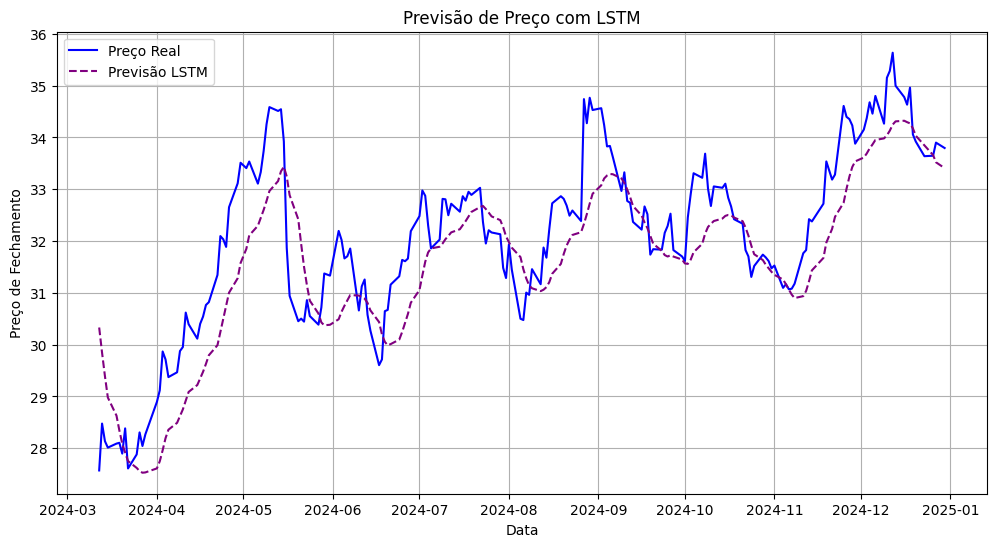

In [77]:
start_idx_plot_rnn = len(df) - len(y_test_original_rnn)
plt.figure(figsize=(12, 6))
plt.plot(df.index[start_idx_plot_rnn:], y_test_original_rnn, label='Preço Real', color='blue')
plt.plot(df.index[start_idx_plot_rnn:], predictions_rnn, label='Previsão LSTM', color='purple', linestyle='--')
plt.title('Previsão de Preço com LSTM')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.grid(True)
plt.show()